In [1]:
import pandas as pd
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
import sys
sys.path.append("../scripts")
import compute_diversity_measures
import seaborn as sns
sns.set(rc={'figure.figsize':(25,15)})

import scipy.stats as stats
from bioinfokit.analys import stat
from statannotations.Annotator import Annotator
from scipy.stats import normaltest

In [2]:
genome_length = 9228

In [3]:
our_color_palette ={"WT": "#F2C14E", "KO": "#F15BB5", "OE": "#368F8B"}
genotype_dict = {"dicer_ko": "KO", "dicer_overexpressed": "OE", "wild_type": "WT"}

### Load mutation calls

In [4]:
fname_mutations_all_samples = 'mutations_of_all_samples_after_filtering.csv'

df = pd.read_csv(fname_mutations_all_samples)
df = df.drop(['Unnamed: 0'], axis=1)
df = df[df['genotype']!='aaa_parental_stock']

In [5]:
df["genotype"] = df["genotype"].apply(lambda x: genotype_dict[x])

### Filter mutations

In [6]:
# minimum mutation frequency
minimum_frequency_threshold = 0.0001 
df = df[df['frequency']>=minimum_frequency_threshold]

In [7]:
# test
df[df['frequency']>=1.0]

,Chromosome,Pos,Ref,Var,Frq1,Frq2,Frq3,Pst1,Pst2,Pst3,...,Pval,Qval,genotype,passage,replicate,n_reads_var,coverage,frequency,Frq_ave,position


### Figure 3A --- Number of polymorphismis

-- compare P1 over all GT with P10 over all GT

In [8]:
# parental stock number of polymorphisms 
# value taken from Notebook: Supplementary_Figure_2__mutation_spectrum_parental_stock_wrt_Cha
# Mutations called wrt to Cha

n_polymorphisms_parental_stock = 265

In [9]:
df_diversity = pd.DataFrame()

for genotype in ['WT', 'KO', 'OE']:
    for passage in [1, 5, 10]:
        for replicate in ['replicate_d', 'replicate_b', 'replicate_a', 'replicate_e','replicate_c']:
            
            df_temp = df[df['genotype']== genotype]
            df_temp = df_temp[df_temp['passage']==passage]
            df_temp = df_temp[df_temp['replicate']==replicate]
            
            dict_t = {'genotype': genotype, 
                      'passage': passage, 
                      'replicate': replicate,
                      'diversity_index': ['number_of_polymorphisms'], 
                      'value': [compute_diversity_measures.number_of_polymorphisms(df_temp, 0.0001)]}
            df_diversity = pd.concat([df_diversity, pd.DataFrame(data=dict_t)])


/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


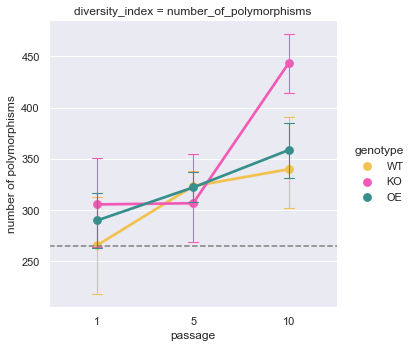

In [10]:
g = sns.catplot(data=df_diversity[df_diversity['diversity_index'].isin(['number_of_polymorphisms'])],
                kind='point',
                  x="passage", 
                  y='value', 
                  hue ='genotype',
                  col='diversity_index', 
                  errorbar="se",
                  order=[1, 5, 10],
                  palette=['#F2C14E', '#F15BB5', '#368F8B'], 
                  errwidth=1.1, 
                  capsize=0.1)

g.ax.set_ylabel('number of polymorphisms')
g.refline(y=265)

## paired t-test 

In [11]:
df_poly = df_diversity[df_diversity['diversity_index'].isin(['number_of_polymorphisms'])][['genotype', 
                                                                                           'passage', 
                                                                                           'replicate', 
                                                                                           'value']]

In [12]:
# test normalitiy --> H0: samples comes from normal distribution
print(normaltest(df_poly['value']).pvalue)

0.2635133984675596


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_OE vs. 5_OE: OE p = 0.037
1_WT vs. 5_WT: WT p = 0.042
5_KO vs. 10_KO: KO p = 0.002
1_KO vs. 10_KO: KO p = 0.004
1_OE vs. 10_OE: OE p = 0.048
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10_KO vs. 10_OE: OE - KO p = 0.007
10_WT vs. 10_KO: WT - KO p = 0.01


/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


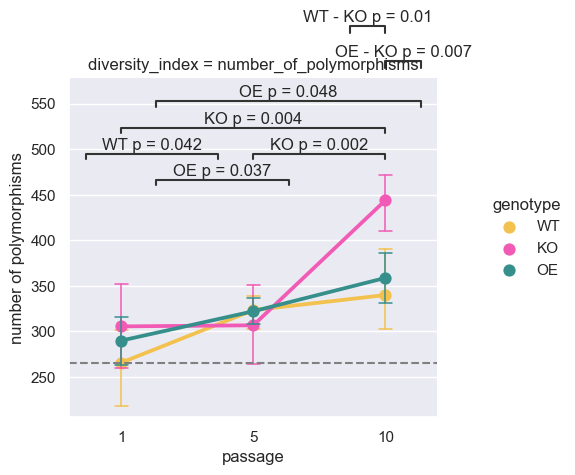

In [13]:
# paired t-test

pairs_subplots = [
                  ((1, "KO"), (10, "KO")),
                  ((1, "OE"), (10, "OE")),
                  ((1, "WT") , (5,"WT")),
                  ((1, "OE"), (5, "OE")),
                  ((5, "KO"), (10, "KO")),
                 ]

pvalues = [
           stats.ttest_rel(df_poly[(df_poly['passage']==1) & (df_poly["genotype"]=="KO")]['value'], 
                           df_poly[(df_poly['passage']==10) & (df_poly["genotype"]=="KO")]['value'], 
                           alternative="two-sided").pvalue,
           stats.ttest_rel(df_poly[(df_poly['passage']==1) & (df_poly["genotype"]=="OE")]['value'], 
                           df_poly[(df_poly['passage']==10) & (df_poly["genotype"]=="OE")]['value'], 
                           alternative="two-sided").pvalue,
           stats.ttest_rel(df_poly[(df_poly['passage']==1) & (df_poly["genotype"]=="WT")]['value'], 
                           df_poly[(df_poly['passage']==5) & (df_poly["genotype"]=="WT")]['value'], 
                           alternative="two-sided").pvalue,
           stats.ttest_rel(df_poly[(df_poly['passage']==1) & (df_poly["genotype"]=="OE")]['value'], 
                           df_poly[(df_poly['passage']==5) & (df_poly["genotype"]=="OE")]['value'], 
                           alternative="two-sided").pvalue,
           stats.ttest_rel(df_poly[(df_poly['passage']==5) & (df_poly["genotype"]=="KO")]['value'], 
                           df_poly[(df_poly['passage']==10) & (df_poly["genotype"]=="KO")]['value'], 
                           alternative="two-sided").pvalue
          ]


formatted_pvalues = [f"{gt} p = {np.around(p,3)}" for gt, p in zip(["KO", "OE","WT", "OE", "KO"], pvalues)]

g = sns.catplot(data=df_diversity[df_diversity['diversity_index'].isin(['number_of_polymorphisms'])],
                kind='point',
                  x="passage", 
                  y='value', 
                  hue ='genotype',
                  col='diversity_index', 
                  errorbar="se",
                  order=[1, 5, 10],
                  palette=['#F2C14E', '#F15BB5', '#368F8B'], 
                  errwidth=1.1, 
                  dodge=0.0,
                  capsize=0.1)

g.set_titles(col_template=' ', row_template=" ")


annot = Annotator(g.ax,
                  pairs_subplots, 
                  data=df_diversity[df_diversity['diversity_index'].isin(['number_of_polymorphisms'])],
                  x="passage", 
                  y='value', 
                  order=[1, 5, 10],
                  hue='genotype', 
                  ) 

annot.configure(test='t-test_paired',loc='inside', verbose=2)
annot.set_custom_annotations(formatted_pvalues)
annot.annotate()

# t-test to compare differences in passage 10 

pairs_subplots =  [((10, "OE"), (10, "KO")),
                  ((10, "WT"), (10, "KO"))]
    
pvalues = [stats.ttest_ind(df_poly[(df_poly['passage']==10) & (df_poly["genotype"]=="OE")]['value'], 
                           df_poly[(df_poly['passage']==10) & (df_poly["genotype"]=="KO")]['value'], 
                           alternative="two-sided").pvalue,
           stats.ttest_ind(df_poly[(df_poly['passage']==10) & (df_poly["genotype"]=="WT")]['value'], 
                           df_poly[(df_poly['passage']==10) & (df_poly["genotype"]=="KO")]['value'], 
                           alternative="two-sided").pvalue]

formatted_pvalues = [f"{gt} p = {np.around(p,3)}" for gt, p in zip(["OE - KO", "WT - KO"], pvalues)]

"""
pairs_subplots =  [((10, "dicer_overexpressed"), (10, "dicer_ko"))]
    
p_values = [
           stats.ttest_rel(df_poly[(df_poly['passage']==10) & (df_poly["genotype"]=="OE")]['value'], 
                           df_poly[(df_poly['passage']==10) & (df_poly["genotype"]=="KO")]['value'], 
                           alternative="two-sided").pvalue]

formatted_pvalues = [f"{gt} p = {p:.2e}" for gt, p in zip([ "OE - KO"], pvalues)]
"""
annot = Annotator(g.ax,
                  pairs_subplots, 
                  data=df_diversity[df_diversity['diversity_index'].isin(['number_of_polymorphisms'])],
                  x="passage", 
                  y='value', 
                  order=[1, 5, 10],
                  hue='genotype', 
                  ) 


annot.configure(test='t-test', verbose=2, loc="outside")
annot.set_custom_annotations(formatted_pvalues)
annot.annotate()

g.ax.set_ylabel('number of polymorphisms')
g.refline(y=265)

In [15]:
g.figure.savefig("./000__Manuscript_figures/Figure_3A__number_of_polymorphisms.pdf")
g.figure.savefig("./000__Manuscript_figures/Figure_3A__number_of_polymorphisms.svg")